In [1]:
import os
import cv2
from glob import glob
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from PIL import Image
import plotly.express as px
from sklearn.model_selection import train_test_split
from tqdm import tqdm # it is used for creating progress meters or progress bars

In [2]:
image_path = f"./BarkVN-50/BarkVN-50_mendeley"
categories = glob(image_path+'/*') 
filedf = pd.DataFrame()
for cat in categories:
    files = glob(cat+'/*')
    tempdf = pd.DataFrame({'filename' : files, 'category' : cat.split("/")[-1]})
    filedf = pd.concat([tempdf,filedf])
filedf.head()

filename  \
0  ./BarkVN-50/BarkVN-50_mendeley\Wrightia religi...   
1  ./BarkVN-50/BarkVN-50_mendeley\Wrightia religi...   
2  ./BarkVN-50/BarkVN-50_mendeley\Wrightia religi...   
3  ./BarkVN-50/BarkVN-50_mendeley\Wrightia religi...   
4  ./BarkVN-50/BarkVN-50_mendeley\Wrightia religi...   

                                category  
0  BarkVN-50_mendeley\Wrightia religiosa  
1  BarkVN-50_mendeley\Wrightia religiosa  
2  BarkVN-50_mendeley\Wrightia religiosa  
3  BarkVN-50_mendeley\Wrightia religiosa  
4  BarkVN-50_mendeley\Wrightia religiosa

In [3]:
grp_count = filedf.groupby('category').aggregate('count').rename(columns = {'filename' : 'count_num'}).reset_index().sort_values(by="count_num",ascending=False)

In [4]:
px.bar(grp_count,x='category',y='count_num',color='category',title='Counts from each category')

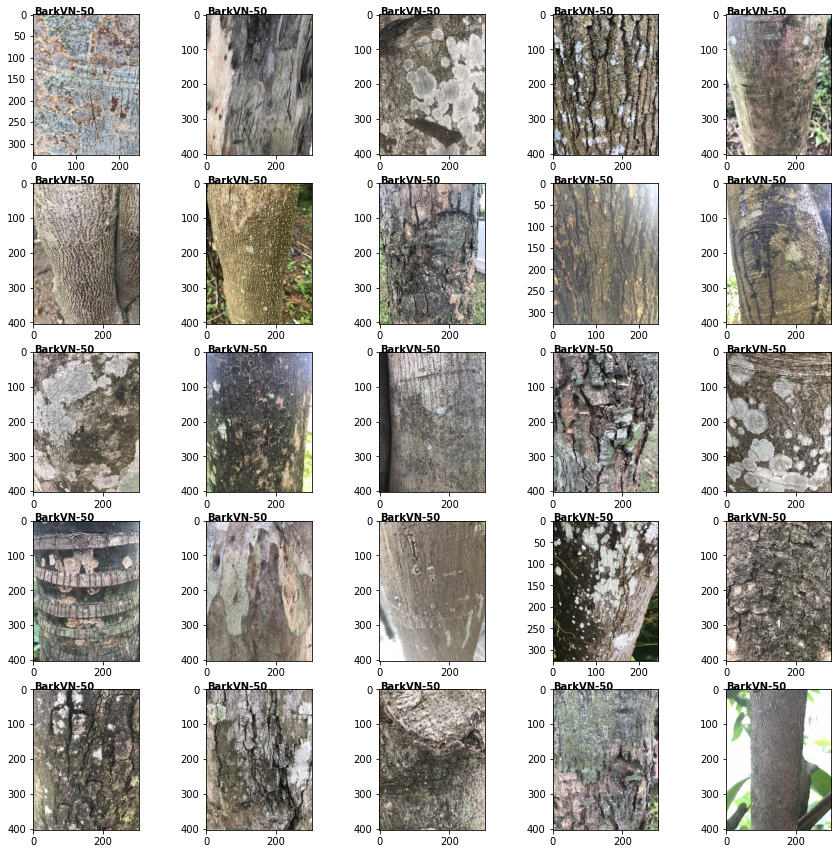

In [5]:
plt.figure(figsize=(15,15))
pd.set_option('mode.chained_assignment', None)
for i in range(25):
    path = filedf.filename.sample(1).values[0]
    category = path.split("/")[-2]
    img = Image.open(path)
    ax = plt.subplot(5,5,i+1)
    ax.annotate(category,xy=(0.90,0.90),weight='bold',size=10)
    plt.imshow(img)

In [6]:
X_train,X_test,_,_ = train_test_split(filedf,
                                      filedf.category,
                                      stratify=filedf.category,
                                      test_size= 0.2)
X_train['type'] = 'train'
X_test['type'] = 'test'
fulldf = pd.concat([X_train,X_test])

In [7]:
import tensorflow as tf
import keras
from sklearn.metrics import confusion_matrix,classification_report
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras import Model,layers,Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Input,Conv2D,GlobalAveragePooling2D,GlobalMaxPool2D,MaxPool2D,BatchNormalization

Using TensorFlow backend.


In [8]:
folder = f"./BarkVN-50/BarkVN-50_mendeley"

show_datagen = ImageDataGenerator(
                               horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5,
                               )
test_datagen = ImageDataGenerator(rescale = 1.0/255.,
                               horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5,
                               validation_split = 0.2)


train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                               horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5,
                                   validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(folder,
                                                    batch_size=64,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(224,224),
                                                   subset = 'training')

# validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

# validation_generator = validation_datagen.flow_from_directory(validation_folder,
#                                                     batch_size=32,
#                                                     shuffle=True,
#                                                     class_mode='categorical',
#                                                     target_size=(224, 224))


test_generator = test_datagen.flow_from_directory(folder,
                                                    batch_size=64,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(224, 224),
                                                 subset = 'validation')

Found 4483 images belonging to 50 classes.
Found 1095 images belonging to 50 classes.


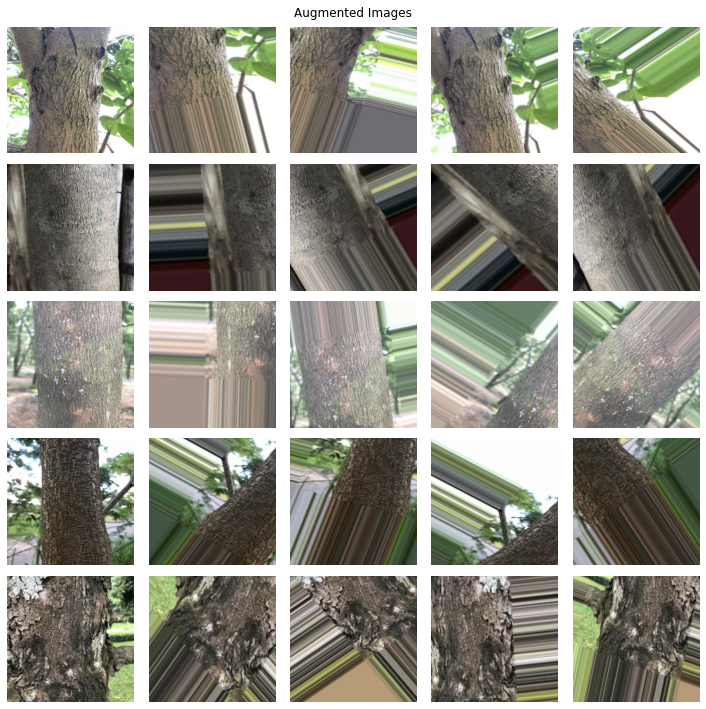

In [9]:
plt.figure(figsize=(10, 10))
plt.suptitle('Augmented Images')

midx = 0
for i in range(5):
    path = filedf.filename.sample(1).values[0]
    orgImg = Image.open(path).resize((200, 200))
    it = show_datagen.flow(np.expand_dims(orgImg, 0), batch_size=1)

    # Original Image
    plt.subplot(5, 5, midx + 1)
    plt.imshow(orgImg)
    plt.axis('off')

    # Augmented Images
    for idx, i in enumerate(range(4)):
        midx += 1
        plt.subplot(5, 5, midx + 1)
        plt.imshow(it.next()[0].astype('uint8'))
        plt.axis('off')
    midx += 1

plt.tight_layout()
plt.savefig('img_aug_show')
plt.show()

In [10]:
def plot_graph(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.title('Loss Graph')
    plt.show()

    # plot the accuracy curve
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.legend()
    plt.title('Accuracy Graph')
    plt.show()

In [11]:
#This function is used to display the classification report , confusion metrics and Modal Accuracy
def conf_matrix(true_value,model_pred):
    
    classes = test_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Modal Accuracy', model_accuracy)
    
    plt.figure(figsize=(50,50))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,cmap=plt.cm.viridis,interpolation='nearest')
    plt.title('Confusion_matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

    print(classification_report(true_value, model_pred, target_names = list(classes)))

In [23]:
def train_vgg_model():
    # Callbacks are created earlystopping is used
    Lrr = ReduceLROnPlateau(monitor='val_acc',factor=0.1,patience=3,min_lr=1e-5)
    vgg19_callbacks = EarlyStopping(monitor="loss",patience=5,verbose=1,mode='auto')
    vgg19_best_model_file = './vgg19_drop_best_weights.h5'
    vgg19_best_model = ModelCheckpoint(vgg19_best_model_file,monitor='val_acc',save_best_only=True,verbose=1)

    #VGG19 model is created with given shapes and include top is set false because we need to add few more layers
    VGG19_model = VGG19(weights='imagenet', pooling='avg',
                               include_top=False,
                               input_shape=(224,224,3),
                               classes=50)

    #layers trainable are set false
    for layer in VGG19_model.layers:
        layer.trainable = False

    last_output = VGG19_model.layers[-1].output
    vgg_x = Flatten()(last_output)
    vgg_x = Dense(512, activation = 'relu')(vgg_x)  #First Dense layer with 512 neuron and relu activation function
    vgg_x = Dropout(0.4)(vgg_x)                     #Dropout layer add with 40%
    vgg_x = Dense(512, activation = 'relu')(vgg_x)  #Second Dense layer with 512 neuron and relu activation function
    vgg_x = Dense(256, activation = 'relu')(vgg_x)  #Third Dense layer with 256 neuron and relu activation function
    vgg_x = Dropout(0.3)(vgg_x)                     #Dropout layer add with 30%
    vgg_x = Dense(50, activation = 'softmax')(vgg_x) #Fourth Dense layer with 50 neuron and softmax activation function
    model = Model(VGG19_model.input, vgg_x)

    model.summary()

    batch_size = 100
    epochs = 50
    learn_rate = 0.001
    adam = Adam(learning_rate=learn_rate)
    model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
    vgg_history = model.fit(train_generator,epochs=epochs,validation_data=test_generator,callbacks=[vgg19_best_model,vgg19_callbacks],verbose=1)
    return model, vgg_history

In [24]:
def train_cnn_model():
    Lrr = ReduceLROnPlateau(monitor='val_acc',factor=0.1,patience=3,min_lr=1e-5)
    callbacks = EarlyStopping(monitor="loss",patience=5,verbose=1,mode='auto')
    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(50, activation='softmax'))

    batch_size = 100
    epochs = 50
    learn_rate = 0.001
    adam = Adam(learning_rate=learn_rate)
    model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
    vgg_history = model.fit(train_generator,epochs=epochs,validation_data=test_generator,callbacks=[callbacks],verbose=1)
    return model, vgg_history

In [34]:
def train_svm_model():
    from keras.applications.nasnet import NASNetLarge
    # from keras.applications.resnet50 import preprocess_input,decode_predictions
    from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten
    from keras.models import Model
    from keras.utils import to_categorical
    from tensorflow import keras
    callbacks = EarlyStopping(monitor="loss",patience=5,verbose=1,mode='auto')
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(50, kernel_regularizer=keras.regularizers.l2(0.02), activation='softmax'))
    model.compile(
        optimizer='adam',
        loss='squared_hinge',
        metrics=['accuracy'],
    )

    model.summary()
    epochs = 50
    learn_rate = 0.001
    history = model.fit(train_generator,epochs=epochs,validation_data=test_generator,callbacks=[callbacks],verbose=1)
    return model, history

In [26]:
# parameters are added
model, history = train_vgg_model()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

E:\Anaconda\envs\tensorflow\lib\site-packages\keras\callbacks.py:707: RuntimeWarning:

Can save best model only with val_acc available, skipping.



Epoch 2/50
71/71 [==============================] - 72s 1s/step - loss: 3.3298 - accuracy: 0.1138 - val_loss: 2.9005 - val_accuracy: 0.2265
Epoch 3/50
71/71 [==============================] - 74s 1s/step - loss: 2.8309 - accuracy: 0.2173 - val_loss: 2.5092 - val_accuracy: 0.3068
Epoch 4/50
71/71 [==============================] - 71s 997ms/step - loss: 2.4918 - accuracy: 0.2775 - val_loss: 2.3088 - val_accuracy: 0.3863
Epoch 5/50
71/71 [==============================] - 72s 1s/step - loss: 2.2494 - accuracy: 0.3482 - val_loss: 2.0745 - val_accuracy: 0.4539
Epoch 6/50
71/71 [==============================] - 70s 992ms/step - loss: 2.1562 - accuracy: 0.3781 - val_loss: 1.8934 - val_accuracy: 0.4913
Epoch 7/50
71/71 [==============================] - 72s 1s/step - loss: 2.0019 - accuracy: 0.3933 - val_loss: 1.8595 - val_accuracy: 0.4785
Epoch 8/50
71/71 [==============================] - 72s 1s/step - loss: 1.9194 - accuracy: 0.4343 - val_loss: 1.8187 - val_accuracy: 0.4521
Epoch 9/50
71/

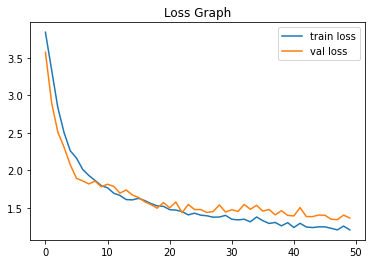

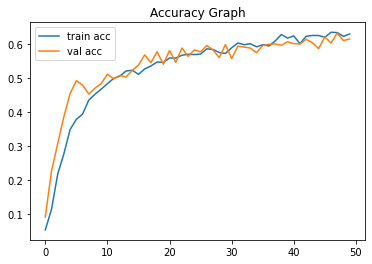

In [27]:
plot_graph(history)

In [28]:
model, history = train_cnn_model()

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 71 steps, validate for 18 steps
Epoch 1/50
71/71 [==============================] - 58s 812ms/step - loss: 3.9896 - accuracy: 0.0335 - val_loss: 3.8532 - val_accuracy: 0.0630
Epoch 2/50
71/71 [==============================] - 58s 811ms/step - loss: 3.8920 - accuracy: 0.0422 - val_loss: 3.9030 - val_accuracy: 0.0429
Epoch 3/50
71/71 [==============================] - 61s 864ms/step - loss: 3.9197 - accuracy: 0.0455 - val_loss: 3.8987 - val_accuracy: 0.0384
Epoch 4/50
71/71 [==============================] - 59s 833ms/step - loss: 3.8995 - accuracy: 0.0375 - val_loss: 3.8936 - val_accuracy: 0.0429
Epoch 5/50
71/71 [==============================] - 57s 800ms/step - loss: 3.8957 - accuracy: 0.0419 - val_loss: 3.8520 - val_accuracy: 0.0429
Epoch 6/50
71/71 [==============================] - 57s 803ms/step - loss: 3.8222 - accuracy: 0.0544 - val_loss: 3.7518 - val_accuracy: 0.0612
Epoch 7/50
71/71 [==============================] 

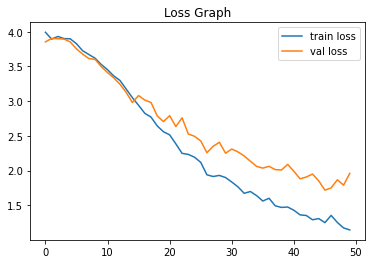

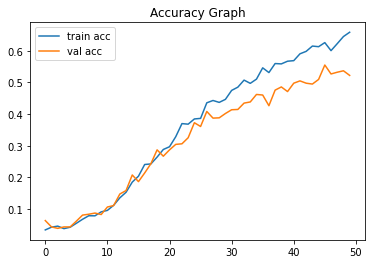

In [29]:
plot_graph(history)

In [32]:
model, history = train_svm_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten_6 (Flatten)          (None, 173056)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)               

Epoch 47/50
71/71 [==============================] - 58s 810ms/step - loss: 1.0287 - accuracy: 0.2697 - val_loss: 1.0289 - val_accuracy: 0.2703
Epoch 48/50
71/71 [==============================] - 57s 806ms/step - loss: 1.0276 - accuracy: 0.2866 - val_loss: 1.0295 - val_accuracy: 0.2612
Epoch 49/50
71/71 [==============================] - 58s 817ms/step - loss: 1.0288 - accuracy: 0.2724 - val_loss: 1.0274 - val_accuracy: 0.2849
Epoch 50/50
71/71 [==============================] - 58s 812ms/step - loss: 1.0288 - accuracy: 0.2748 - val_loss: 1.0299 - val_accuracy: 0.2667


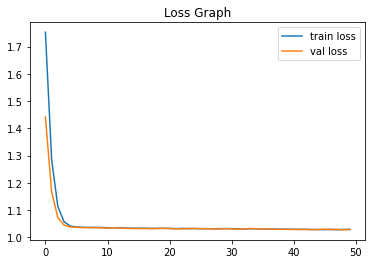

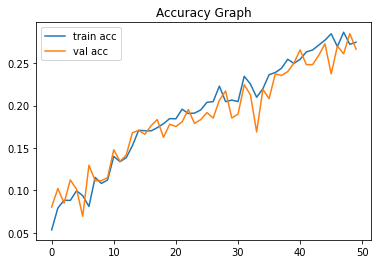

In [35]:
plot_graph(history)